In [1]:
import os 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import cv2

## Introduction 

This is a simplified version of updating image over a mask region, mainly to give reader of the coder an understanding of hot to update gradient over a specific region and how the receptive field may influyence the whole things


In [2]:
model = models.vgg16(pretrained=True).features
net = nn.Sequential()
for i, layer in enumerate(list(model)):
    if i <= 9:
        net.add_module(str(len(net)), layer)
print(net)
for param in net.parameters(): # freeze new added loss layer 
    param.requires_grad = False


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## Set Data, Target


In [3]:
def tensor_to_np_img(x):
    x_np = x.detach().numpy()
    x_np = np.squeeze(x_np, axis=0)
    x_np = np.dstack((x_np[0, :, :], x_np[1, :, :], x_np[2, :, :]))
    return x_np

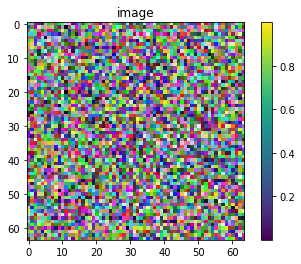

In [4]:
img = torch.rand((1, 3, 64, 64))
img = nn.Parameter(img)
plt.figure()
plt.title('image')
plt.imshow(tensor_to_np_img(img))
plt.colorbar()
plt.show()

In [5]:
optimizer = optim.Adam([img], 1e-2)

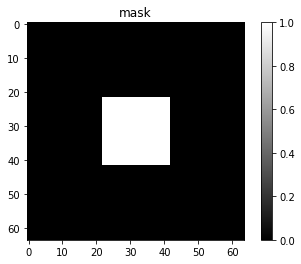

mask shape is: torch.Size([1, 1, 64, 64])


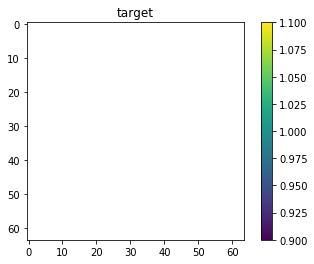

In [6]:
target = torch.ones((img.shape))
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 22:42, 22:42] = 1 
plt.figure()
plt.title('mask')
plt.imshow(mask[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()
print('mask shape is:',mask.shape)
plt.figure()
plt.title('target')
plt.imshow(tensor_to_np_img(target))
plt.colorbar()
plt.show()


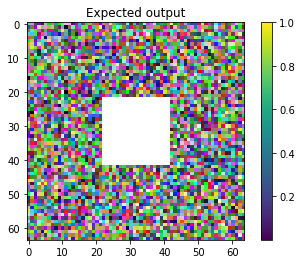

Expected output shape : torch.Size([1, 3, 64, 64])


In [7]:
expected_output = (1-mask.expand(img.shape)) * img + mask.expand(img.shape) * target
plt.figure()
plt.imshow(tensor_to_np_img(expected_output))
plt.title('Expected output')
plt.colorbar()
plt.show()
print('Expected output shape :', expected_output.shape)

In [8]:
target_fm = net(target)
print(target_fm.shape)

torch.Size([1, 128, 16, 16])


In [ ]:
mask_fm = F.interpolate(mask, scale_factor=(0.25, 0.25))
mask_fm = mask_fm.expand(target_fm.shape)
print(mask_fm.shape)

torch.Size([1, 128, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


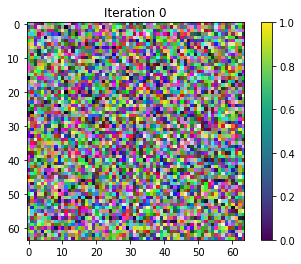

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


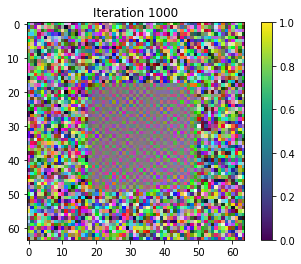

Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


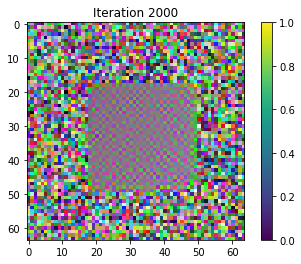

Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


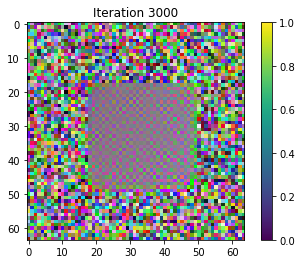

Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


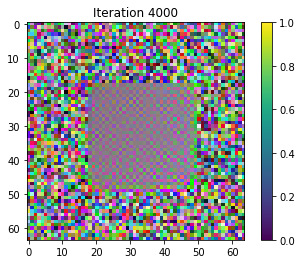

Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


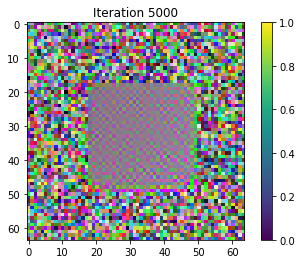

Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


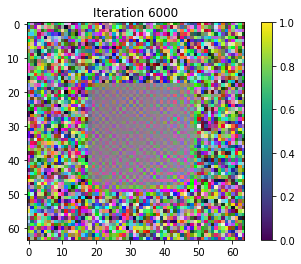

Iteration 6000
Iteration 6100


In [ ]:
i = 0
while i < 8000:
    optimizer.zero_grad()
    img_fm = net(img)
    diff = (img_fm - target_fm)**2
    diff_mask = diff * mask_fm
    loss = torch.sum(diff_mask)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        img_np = tensor_to_np_img(img)
        plt.imshow(img_np)
        plt.colorbar()
        plt.title('Iteration {}'.format(str(i)))
        plt.show()
    if i % 100 == 0:
        print('Iteration {}'.format(i))
    i += 1

**NOTICE**, the whole area inside the receptive field may be influenced